In this notebook, we will build a 3D map of a scene from a small set of images and then localize an image downloaded from the Internet. This demo was contributed by [Philipp Lindenberger](https://github.com/Phil26AT/).

In [1]:
!git clone --recursive https://github.com/KOE-Wayfind/Hierarchical-Localization
%cd Hierarchical-Localization
%pip install -e .
%pip install --upgrade --quiet plotly

fatal: destination path 'Hierarchical-Localization' already exists and is not an empty directory.
/workspaces/HLOC/Hierarchical-Localization
Obtaining file:///workspaces/HLOC/Hierarchical-Localization
  Preparing metadata (setup.py) ... done
  Attempting uninstall: hloc
    Found existing installation: hloc 1.3
    Uninstalling hloc-1.3:
      Successfully uninstalled hloc-1.3
  Running setup.py develop for hloc

[notice] A new release of pip is available: 23.1.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import tqdm, tqdm.notebook
tqdm.tqdm = tqdm.notebook.tqdm  # notebook-friendly progress bars
from pathlib import Path

from hloc import extract_features, match_features, reconstruction, visualization, pairs_from_exhaustive
from hloc.visualization import plot_images, read_image
from hloc.utils import viz_3d

In [3]:
# back to content dir (home)
%cd ..

/workspaces/HLOC


# Setup

In [4]:
# Get image datasets

!git clone https://github.com/KOE-Wayfind/koe-datasets

fatal: destination path 'koe-datasets' already exists and is not an empty directory.


Here we define some output paths. We will use SuperPoint local features with the SuperGlue matcher, but it's easy to switch to other features like SIFT or R2D2.

In [5]:
images = Path('koe-datasets/small')
outputs = Path('outputs/demo/')
!rm -rf $outputs
sfm_pairs = outputs / 'pairs-sfm.txt'
loc_pairs = outputs / 'pairs-loc.txt'
sfm_dir = outputs / 'sfm'
features = outputs / 'features.h5'
matches = outputs / 'matches.h5'

# feature_conf = extract_features.confs['superpoint_aachen'] # for outdoor
feature_conf = extract_features.confs['superpoint_inloc'] # for indoor
matcher_conf = match_features.confs['superglue']

# 3D mapping
First we list the images used for mapping. These are all day-time shots of KOE Building.

['day/e1-l2-conference-room-a_2.jpg', 'day/e1-l2-conference-room-b_7.jpg', 'day/e1-l2-alpha-lr26_2.jpg', 'day/e1-l2-osc_2.jpg', 'day/e1-l2-conference-room-b_1.jpg', 'day/e1-l2-oddaa_1.jpg', 'day/e1-l2-osc_5.jpg', 'day/e1-l2-notice-board_1.jpg', 'day/e1-l2-osc_4.jpg', 'day/e1-l2-conference-room-a_4.jpg', 'day/e1-l2-conference-room-a_1.jpg', 'day/e1-l2-conference-room-b_5.jpg', 'day/e1-l2-osc_1.jpg', 'day/e1-l2-conference-room-a_3.jpg', 'day/e1-l2-academic-staff-room_2.jpg', 'day/e1-l2-enginius-office_2.jpg', 'day/e1-l2-oddaa_2.jpg', 'day/e1-l2-conference-room-b_6.jpg', 'day/e1-l2-conference-room-b_4.jpg', 'day/e1-l2-conference-room-b_3.jpg', 'day/e1-l2-academic-staff-room_3.jpg', 'day/e1-l2-alpha-lr26_1.jpg', 'day/e1-l2-conference-room-b_2.jpg', 'day/e1-l2-osc_3.jpg', 'day/e1-l2-enginius-office_1.jpg', 'day/e1-l2-conference-room-a_5.jpg', 'day/e1-l2-conference-room-a_6.jpg', 'day/e1-l2-academic-staff-room_1.jpg', 'day/e1-l2-notice-board_2.jpg']
29 mapping images


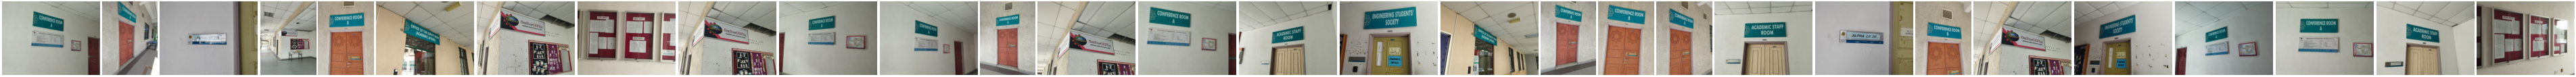

In [6]:
landmark = "e1-l2*.jpg" # Use * for wildcard
references = [str(p.relative_to(images)) for p in (images / 'day/').glob(landmark)]
print(references)
print(len(references), "mapping images")
plot_images([read_image(images / r) for r in references], dpi=25)

Then we extract features and match them across image pairs. Since we deal with few images, we simply match all pairs exhaustively. For larger scenes, we would use image retrieval, as demonstrated in the other notebooks.

In [7]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [8]:
extract_features.main(feature_conf, images, image_list=references, feature_path=features)
print("done extract features")
pairs_from_exhaustive.main(sfm_pairs, image_list=references)
print("done pairs_from_echaustive")
match_features.main(matcher_conf, sfm_pairs, features=features, matches=matches);

[2023/06/12 16:13:15 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 4},
 'output': 'feats-superpoint-n4096-r1600',
 'preprocessing': {'grayscale': True, 'resize_max': 1600}}


Loaded SuperPoint model


  0%|          | 0/29 [00:00<?, ?it/s]

[2023/06/12 16:13:25 hloc INFO] Finished exporting features.
[2023/06/12 16:13:25 hloc INFO] Found 406 pairs.
[2023/06/12 16:13:25 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}


done extract features
done pairs_from_echaustive
Loaded SuperGlue model ("outdoor" weights)


  0%|          | 0/406 [00:00<?, ?it/s]

[2023/06/12 16:14:59 hloc INFO] Finished exporting matches.


Then we run incremental Structure-from-Motion and display the reconstructed 3D model.

In [9]:
model = reconstruction.main(sfm_dir, images, sfm_pairs, features, matches, image_list=references)
fig = viz_3d.init_figure()
viz_3d.plot_reconstruction(fig, model, color='rgba(255,0,0,0.5)', name="mapping")
fig.show()

[2023/06/12 16:14:59 hloc INFO] Creating an empty database...
[2023/06/12 16:14:59 hloc INFO] Importing images into the database...
[2023/06/12 16:14:59 hloc INFO] Importing features into the database...


  0%|          | 0/29 [00:00<?, ?it/s]

[2023/06/12 16:14:59 hloc INFO] Importing matches into the database...


  0%|          | 0/406 [00:00<?, ?it/s]

[2023/06/12 16:15:00 hloc INFO] Performing geometric verification of the matches...
[2023/06/12 16:15:01 hloc INFO] Running 3D reconstruction...
[2023/06/12 16:15:05 hloc INFO] Reconstructed 1 model(s).
[2023/06/12 16:15:05 hloc INFO] Largest model is #0 with 22 images.
[2023/06/12 16:15:05 hloc INFO] Reconstruction statistics:
Reconstruction:
	num_reg_images = 22
	num_cameras = 3
	num_points3D = 770
	num_observations = 3642
	mean_track_length = 4.72987
	mean_observations_per_image = 165.545
	mean_reprojection_error = 0.882561
	num_input_images = 29


We also visualize which keypoints were triangulated into the 3D model.

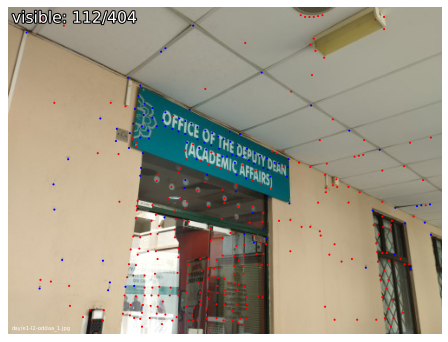

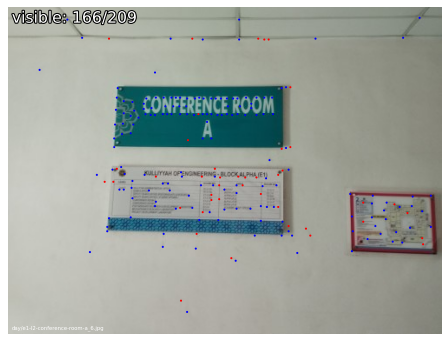

In [10]:
visualization.visualize_sfm_2d(model, images, color_by='visibility', n=2)

# Localization
Now that we have a 3D map of the scene, we can localize any image. To demonstrate this, we download [a night-time image from Wikimedia](https://commons.wikimedia.org/wiki/File:Paris_-_Basilique_du_Sacr%C3%A9_Coeur,_Montmartre_-_panoramio.jpg).

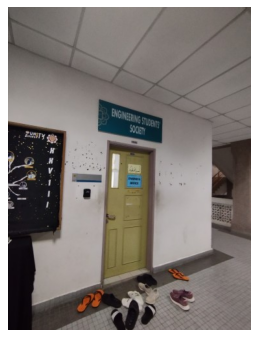

In [11]:
# query = 'night/e1-l2-conference-room-b_3.jpg'
query = 'night/e1-l2-enginius-office_4.jpg'

plot_images([read_image(images / query)], dpi=75)

Again, we extract features for the query and match them exhaustively with all mapping images that were successfully reconstructed.

In [12]:
references_registered = [model.images[i].name for i in model.reg_image_ids()]
extract_features.main(feature_conf, images, image_list=[query], feature_path=features, overwrite=True)
pairs_from_exhaustive.main(loc_pairs, image_list=[query], ref_list=references_registered)
match_features.main(matcher_conf, loc_pairs, features=features, matches=matches, overwrite=True);

[2023/06/12 16:15:52 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 4},
 'output': 'feats-superpoint-n4096-r1600',
 'preprocessing': {'grayscale': True, 'resize_max': 1600}}


Loaded SuperPoint model


  0%|          | 0/1 [00:00<?, ?it/s]

[2023/06/12 16:15:52 hloc INFO] Finished exporting features.
[2023/06/12 16:15:52 hloc INFO] Found 22 pairs.
[2023/06/12 16:15:52 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}


Loaded SuperGlue model ("outdoor" weights)


  0%|          | 0/22 [00:00<?, ?it/s]

[2023/06/12 16:15:58 hloc INFO] Finished exporting matches.


We read the EXIF data of the query to infer a rough initial estimate of camera parameters like the focal length. Then we estimate the absolute camera pose using PnP+RANSAC and refine the camera parameters.

found 188/315 inlier correspondences.
Match percentage 59.682539682539684
here
day/e1-l2-enginius-office_1.jpg
here
day/e1-l2-conference-room-b_6.jpg


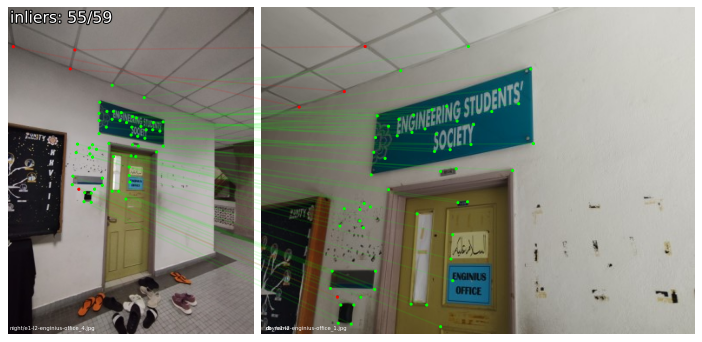

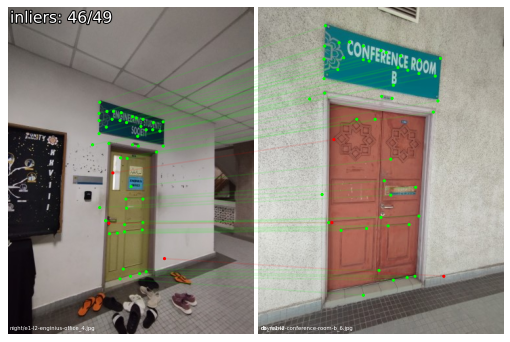

In [13]:
import pycolmap
import numpy as np
from hloc.localize_sfm import QueryLocalizer, pose_from_cluster

camera = pycolmap.infer_camera_from_image(images / query)
ref_ids = [model.find_image_with_name(n).image_id for n in references_registered]
conf = {
    'estimation': {'ransac': {'max_error': 12}},
    'refinement': {'refine_focal_length': True, 'refine_extra_params': True},
}
localizer = QueryLocalizer(model, conf)
ret, log = pose_from_cluster(localizer, query, camera, ref_ids, features, matches)

print(f'found {ret["num_inliers"]}/{len(ret["inliers"])} inlier correspondences.')
percent_match = (ret["num_inliers"]/len(ret["inliers"])) * 100
print(f'Match percentage {percent_match}')
visualization.visualize_loc_from_logd(images, query, log, model)

We visualize the correspondences between the query images a few mapping images. We can also visualize the estimated camera pose in the 3D map.

In [14]:
pose = pycolmap.Image(tvec=ret['tvec'], qvec=ret['qvec'])
viz_3d.plot_camera_colmap(fig, pose, camera, color='rgba(0,255,0,0.5)', name=query)
fig.show()